<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" /> 
    
    
### <font color='navy'> Modelos no lineales para pronósticos. 

**Nombres:** Paula Daniela Cárdenas Gallardo y Rafael Gallardo Vázquez.

**Fecha:** 7 de febrero del 2023.

**Expediente** : 7333720 y ######.
    
**Profesor:** Óscar David Jaramillo Zuluaga.
    
**Link Github**: [github.com](https://github.com/paucardenasg/ProyectoConjunto_PDC-RDENAS_RGALLARDO)

# Tarea 2: Clase 4

## Enunciado de tarea
> Para ejemplo estudiado en esta clase data WWWUsage.csv probar lo siguiente:
> 1. Encontrar el mejor modelo ARIMA usando los criterios de AIC, BIC y log-verosimilud, justificando la estructura propuesta.
2. Analizar el efecto de normalizar la serie de tiempo, es decir usar MinMaxScaler para normalizar los datos. Posterior a esto, realizar el mismo precedimiento realizado en clase y encontrar el mejor modelo de ARIMA. Justifique todos los análisis realizados, incluyendo los resultados de las gráficas de ACF y PAC.
3. Investigar la implementación y teoría de los modelos SARIMAX. Además de eso, generar un modelo de pronóstico usando SARIMAX, donde todo el procediemiento anteriormente descrito es implementado.
4. Realizar una predicción de 20 unidades de tiempo en el futuro, tanto para el modelo ARIMA como SARIMA y reportar los resulados en una gráfica donde se puedan observar los datos reales y los datos predichos.

### Ejercicio 1: Encontrar el mejor modelo ARIMA usando los criterios de AIC, BIC y log-verosimilud, justificando la estructura propuesta.

Código de solución estudiante 1

In [1]:
# Librerías
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from io import BytesIO
import pandas as pd
import requests
import datetime
import warnings
warnings.filterwarnings("ignore")
plt.rc("font", size=12)

In [2]:
# Cargar los datos
data = pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/datasets/WWWusage.csv', names=[ 'values'], header=0)
data.index = data.index.droplevel()
data.head()

,values
1,88
2,84
3,85
4,85
5,84


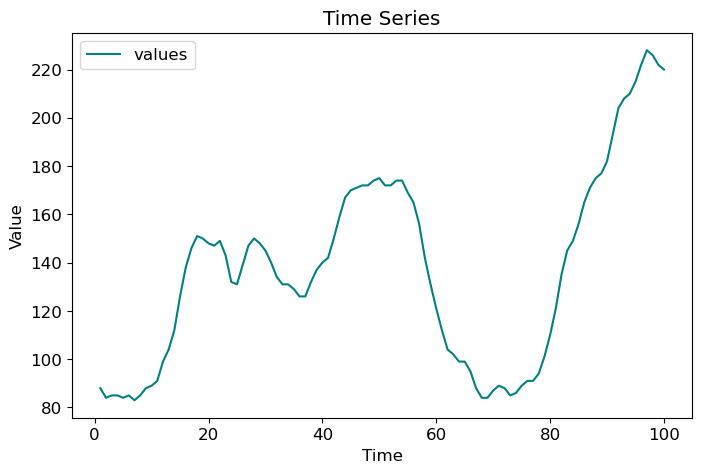

In [3]:
# Visualizar los datos
data.plot(figsize=(8,5), color='teal')
plt.title('Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [4]:
# Dividir en entrenamiento (80%) y prueba (20%)
train = data.iloc[:80]
test = data.iloc[80:]

In [5]:
# Función para probar estacionariedad
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
    if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [6]:
# Probar estacionariedad
adf_test(train)

Results of Dickey-Fuller Test:
Test Statistic                 -2.649346
p-value                         0.083221
#Lags Used                      3.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64
Non-stationary


In [7]:
# Diferenciar la serie
diff1_values = train.diff().dropna()
print('ADF para derivada primer orden...\n')
adf_test(diff1_values)

diff2_values = train.diff().diff().dropna()
print('ADF para derivada segundo orden...\n')
adf_test(diff2_values)

ADF para derivada primer orden...

Results of Dickey-Fuller Test:
Test Statistic                 -2.504537
p-value                         0.114374
#Lags Used                      2.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64
Non-stationary
ADF para derivada segundo orden...

Results of Dickey-Fuller Test:
Test Statistic                -8.236551e+00
p-value                        5.869012e-13
#Lags Used                     1.000000e+00
Number of Observations Used    7.600000e+01
Critical Value (1%)           -3.519481e+00
Critical Value (5%)           -2.900395e+00
Critical Value (10%)          -2.587498e+00
dtype: float64
Stationary


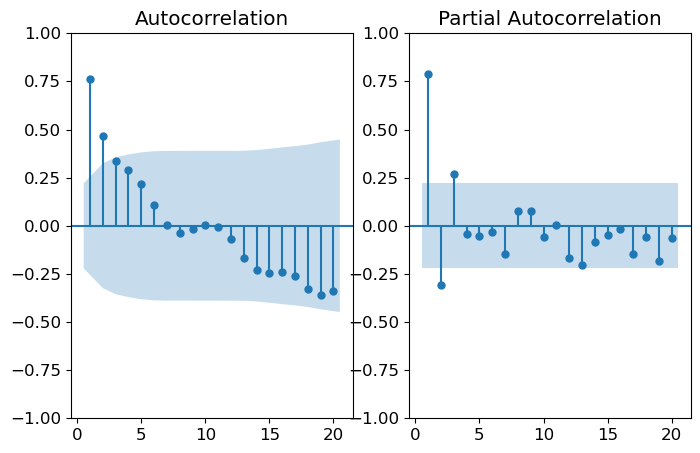

In [8]:
# Graficar ACF y PACF
def plot_acf_pacf(data, kwargs=dict()):
    f = plt.figure(figsize=(8,5))

    ax1 = f.add_subplot(121)

    plot_acf(data, zero=False, ax=ax1, **kwargs)

    ax2 = f.add_subplot(122)
    plot_pacf(data, zero=False, ax=ax2, method='ols', **kwargs)

    plt.show()

# Primera diferenciación
plot_acf_pacf(diff1_values, {'lags':20})

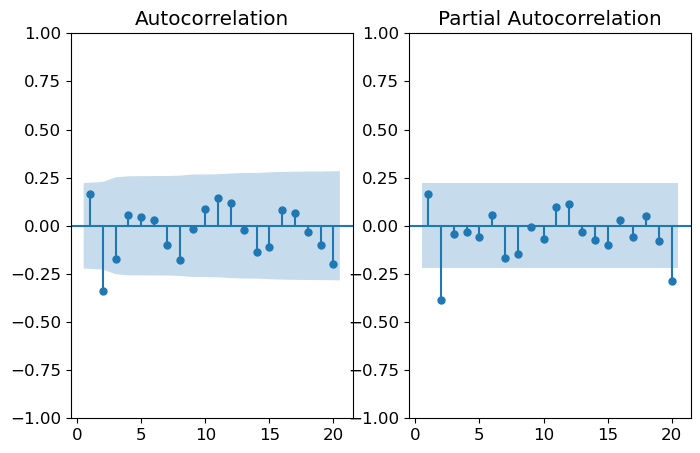

In [9]:
# Segunda diferenciación
plot_acf_pacf(diff2_values, {'lags':20})

In [10]:
# Modelo de diferencia de primer orden
arima_model_base = ARIMA(train, order=(3, 1, 4))
model_base = arima_model_base.fit()
print(model_base.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                   80
Model:                 ARIMA(3, 1, 4)   Log Likelihood                -200.159
Date:                Tue, 07 Feb 2023   AIC                            416.318
Time:                        13:18:23   BIC                            435.274
Sample:                             0   HQIC                           423.912
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5332      0.286      5.359      0.000       0.972       2.094
ar.L2         -1.0904      0.460     -2.368      0.018      -1.993      -0.188
ar.L3          0.1934      0.293      0.661      0.5

In [11]:
# Modelo de diferencia de segundo orden
# Términos de AR
ar = (0, 1)  # (alpha1, alpha2)
# Términos de MA
ma = (0, 1)  # (beta1, beta2)

arima_model_base2 = ARIMA(train, order=(ar, 2, ma))
model_base2 = arima_model_base2.fit()
print(model_base2.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                   80
Model:             ARIMA([2], 2, [2])   Log Likelihood                -204.918
Date:                Tue, 07 Feb 2023   AIC                            415.836
Time:                        13:18:23   BIC                            422.906
Sample:                             0   HQIC                           418.666
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2         -0.1580      0.299     -0.528      0.598      -0.744       0.428
ma.L2         -0.2139      0.299     -0.716      0.474      -0.799       0.372
sigma2        11.1660      2.019      5.531      0.0

Una vez revisados los modelos base vistos en clase, probaremos un modelo ARIMA con los siguientes parámetros:
+ $p=3 \rightarrow$ por los tres sesgos de correlación que vemos en la gráfica de *PACF*
+ $d=1 \rightarrow$ por la primera diferenciación, aunque salga como "no estacionaria" en la prueba Dickey-Fuller, el *p-value* es aceptable desde mi criterio
+ $q=1\rightarrow$ por el primer sesgo de correlación que vemos en la gráfica de *ACF*, ya que es mucho mayor que los otros tres que sobresalen del rango de significancia

In [12]:
# Modelo de diferencia de primer orden
arima_model_1 = ARIMA(train, order=(3, 1, 1))
model_1 = arima_model_1.fit()
print(model_1.summary())

                               SARIMAX Results                                
Dep. Variable:                 values   No. Observations:                   80
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -202.231
Date:                Tue, 07 Feb 2023   AIC                            414.462
Time:                        13:18:23   BIC                            426.309
Sample:                             0   HQIC                           419.209
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0024      0.437      2.295      0.022       0.146       1.858
ar.L2         -0.4731      0.475     -0.997      0.319      -1.403       0.457
ar.L3          0.2333      0.192      1.218      0.2

___
**`Observaciones:`** <br>
+ **Log-Likelihood**: $-202.231$ está entre los dos resultados anteriores, por lo que no mejoró mucho
+ **Criterio de información de Akaike**: $414.462$ es ligeramente menor a los modelos anteriores, lo cual es buena señal
+ **Criterio de información bayesiano**: $426.309$ está entre los dos valores anteriores
+ **Ljung-Box**: como el *p-value* es mayor a $0.5$ no se rechaza la hipótesis nula y los datos se distribuyen de forma independiente
+ **Heterocedasticidad**: como el *p-value* es mayor a $0.5$ no se rechaza la hipótesis nula y los residuos muestran varianza cambiante
+ **Jarque-Bera**: como el *p-value* es mayor a $0.5$ no se rechaza la hipótesis nula y los datos se distribuyen normalmente
___

<AxesSubplot:>

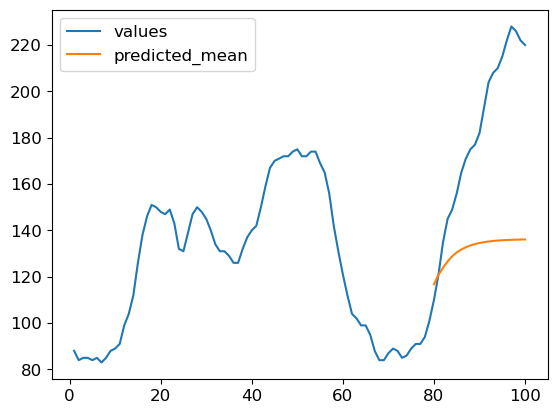

In [13]:
# Cómo realizar predicciones con el modelo ajustado
y_h = model_1.predict(start=80, end=100, dynamic=False).to_frame()
ax = data.plot()
y_h.plot(ax=ax)

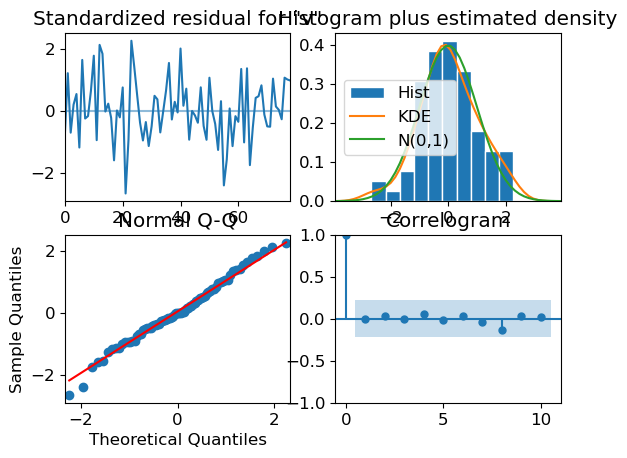

In [14]:
# Gráfico de los diagnósticos para los residuos
model_1.plot_diagnostics();

Código de solución estudiante 2

In [ ]:
# Código de solución estudiante 2
.
.
.
.


### Respuesta planteada en el ejercicio usando
La respuesta es un modelo ARIMA con parámetros:
+ $p=$
+ $d=$
+ $q=$

### Ejercicio 2: Analizar el efecto de normalizar la serie de tiempo, es decir usar MinMaxScaler para normalizar los datos. Posterior a esto, realizar el mismo precedimiento realizado en clase y encontrar el mejor modelo de ARIMA. Justifique todos los análisis realizados, incluyendo los resultados de las gráficas de ACF y PAC.

Código de solución estudiante 1

In [15]:
# Cargar datos
data = pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/datasets/WWWusage.csv', names=[ 'values'], header=0)
data.index = data.index.droplevel()

In [16]:
# Dividir en entrenamiento (80%) y prueba (20%)
train = data.iloc[:80]
test = data.iloc[80:]

In [17]:
# Normalización
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(train)

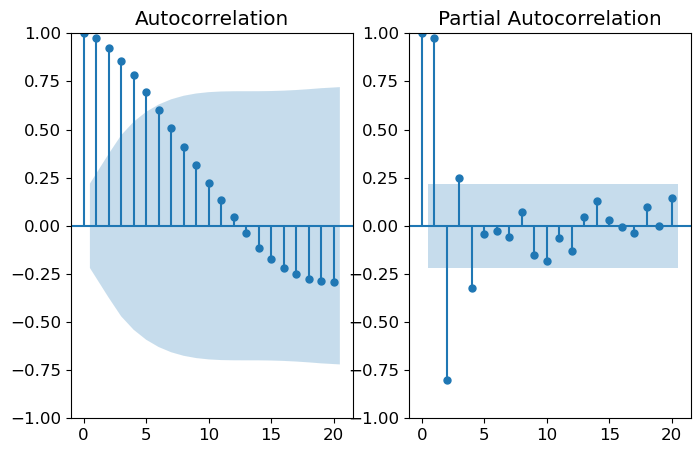

In [18]:
# Escoger parámetros de ARIMA

# Graficar ACF y PACF
f = plt.figure(figsize=(8,5))

ax1 = f.add_subplot(121)

plot_acf(scaled_data, ax=ax1)

ax2 = f.add_subplot(122)
plot_pacf(scaled_data, ax=ax2, method='ols')

plt.show()

In [19]:
# Checar estacionariedad
adf_test(scaled_data)

Results of Dickey-Fuller Test:
Test Statistic                 -2.649346
p-value                         0.083221
#Lags Used                      3.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64
Non-stationary


In [20]:
# Diferenciar
diff1_values = pd.DataFrame(scaled_data).diff().dropna()

print('ADF para derivada primer orden...\n')
adf_test(diff1_values)

diff2_values = pd.DataFrame(scaled_data).diff().diff().dropna()

print('ADF para derivada segundo orden...\n')
adf_test(diff2_values)

ADF para derivada primer orden...

Results of Dickey-Fuller Test:
Test Statistic                 -2.504537
p-value                         0.114374
#Lags Used                      2.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64
Non-stationary
ADF para derivada segundo orden...

Results of Dickey-Fuller Test:
Test Statistic                -8.236551e+00
p-value                        5.869012e-13
#Lags Used                     1.000000e+00
Number of Observations Used    7.600000e+01
Critical Value (1%)           -3.519481e+00
Critical Value (5%)           -2.900395e+00
Critical Value (10%)          -2.587498e+00
dtype: float64
Stationary


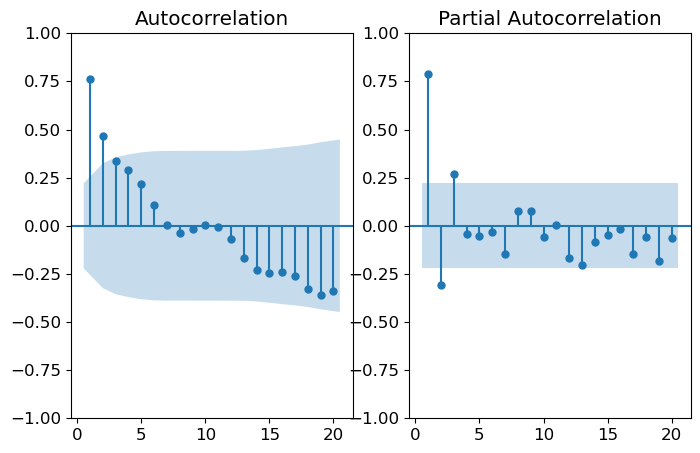

In [21]:
# Autocorrelación primera diferenciación
plot_acf_pacf(diff1_values, {'lags':20})

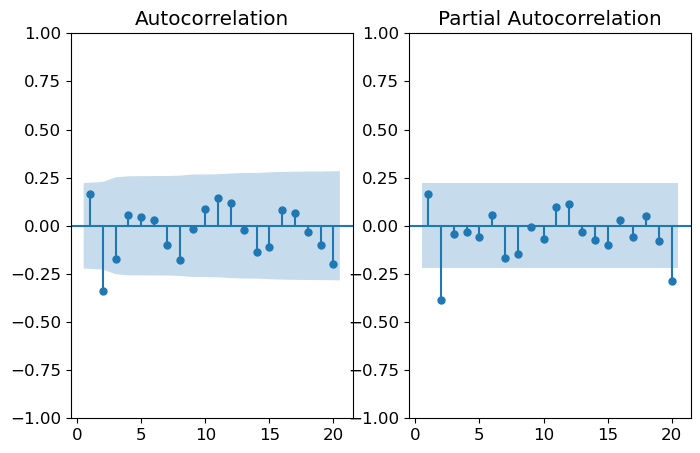

In [22]:
# Autocorrelación segunda diferenciación
plot_acf_pacf(diff2_values, {'lags':20})

In [23]:
# Modelo de diferencia de primer orden
arima_model_scaled_1 = ARIMA(scaled_data, order=(3, 1, 2))
model_scaled_1 = arima_model_scaled_1.fit()
print(model_scaled_1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:                 ARIMA(3, 1, 2)   Log Likelihood                 155.633
Date:                Tue, 07 Feb 2023   AIC                           -299.266
Time:                        13:18:42   BIC                           -285.049
Sample:                             0   HQIC                          -293.570
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1443      0.228     -0.634      0.526      -0.590       0.302
ar.L2          0.1464      0.227      0.645      0.519      -0.298       0.591
ar.L3          0.3054      0.189      1.613      0.1

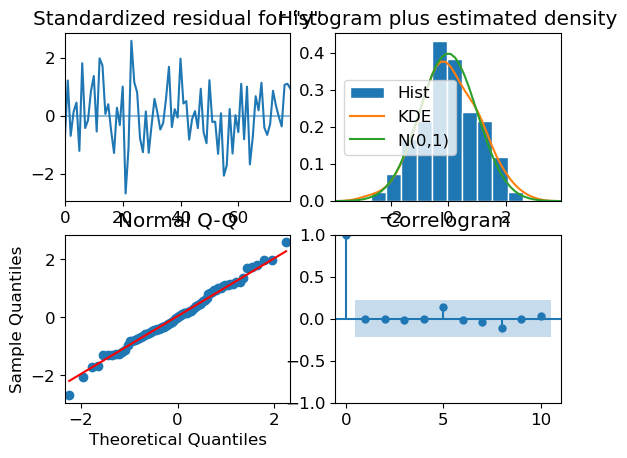

In [25]:
# Gráfico de los diagnósticos para los residuos
model_scaled_1.plot_diagnostics();

In [26]:
# Modelo de diferencia de segundo orden
ar = (0, 1)
ma = (0, 1)
arima_model_scaled_2 = ARIMA(scaled_data, order=(ar, 2, ma))
model_scaled_2 = arima_model_scaled_2.fit()
print(model_scaled_2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:             ARIMA([2], 2, [2])   Log Likelihood                 147.782
Date:                Tue, 07 Feb 2023   AIC                           -289.563
Time:                        13:18:43   BIC                           -282.493
Sample:                             0   HQIC                          -286.733
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L2         -0.1578      0.299     -0.528      0.598      -0.744       0.428
ma.L2         -0.2140      0.299     -0.717      0.474      -0.799       0.371
sigma2         0.0013      0.000      5.533      0.0

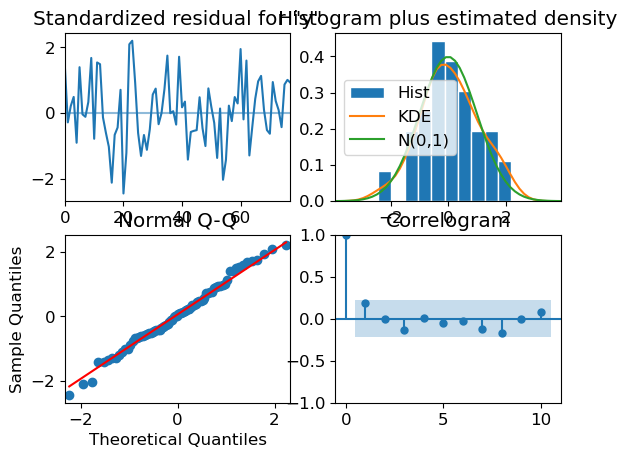

In [28]:
# Gráfico de los diagnósticos para los residuos
model_scaled_2.plot_diagnostics();

___
**`Observaciones:`** <br>
+ **Log-Likelihood**: el primer modelo tiene una verosimilitud mayor, lo cual es mejor
+ **Criterio de información de Akaike**: el segundo modelo tiene un valor menor, lo cual es mejor
+ **Criterio de información bayesiano**: el segundo modelo tiene un valor menor, lo cual es mejor
+ **Ljung-Box**: como el *p-value* es mayor a $0.5$ no se rechaza la hipótesis nula y los datos se distribuyen de forma independiente, aunque el segundo modelo tiene un *p-value* mucho menor que el primero
+ **Heterocedasticidad**: como el *p-value* es mayor a $0.5$ no se rechaza la hipótesis nula y los residuos muestran varianza cambiante
+ **Jarque-Bera**: como el *p-value* es mayor a $0.5$ no se rechaza la hipótesis nula y los datos se distribuyen normalmente
+ Cuando los datos se normalizan desde un inicio parece haber mejores resultados.
___

Código de solución estudiante 2

In [ ]:
# Código de solución estudiante 2
.
.
.
.


### Respuesta planteada en el ejercicio
 La respuesta es un modelo ARIMA con los siguientes parámetros:
 + $p=$
 + $d=$
 + $q=$

### Ejercicio 3: Investigar la implementación y teoría de los modelos SARIMAX. Además de eso, generar un modelo de pronóstico usando SARIMAX, donde todo el procediemiento anteriormente descrito es implementado.

Código de solución estudiante 1

In [29]:
# Cargar datos
air2 = requests.get('https://www.stata-press.com/data/r12/air2.dta').content
data2 = pd.read_stata(BytesIO(air2))
data2.index = pd.date_range(start=datetime.datetime(data2.time[0], 1, 1), periods=len(data2), freq='MS')
data2.drop('time', axis=1, inplace=True)
data2.head()

,air,t
1949-01-01,112,1.0
1949-02-01,118,2.0
1949-03-01,132,3.0
1949-04-01,129,4.0
1949-05-01,121,5.0


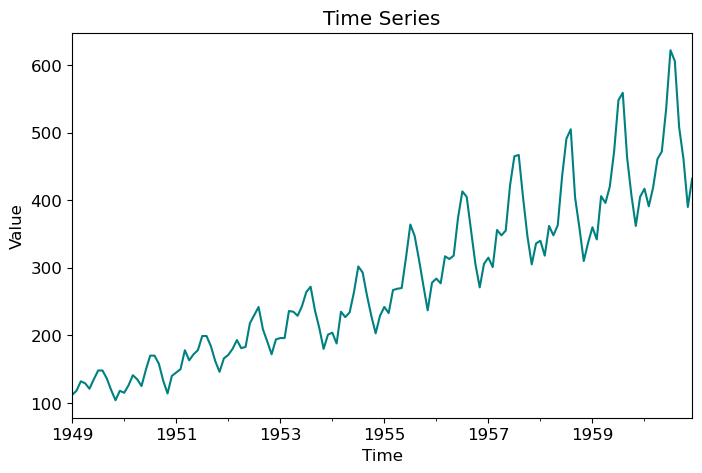

In [30]:
# Visualizar los datos
data2['air'].plot(figsize=(8,5), color='teal')
plt.title('Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

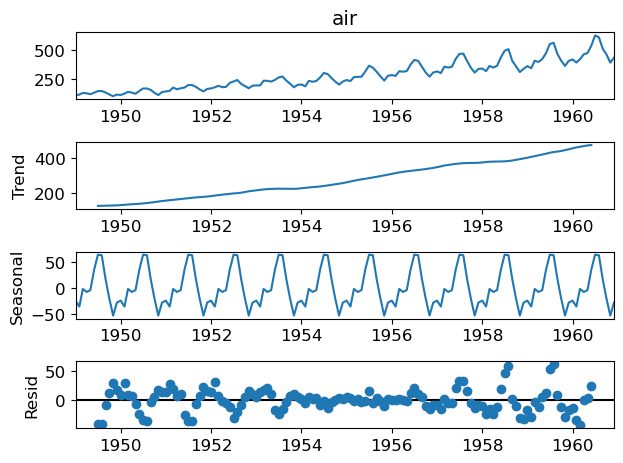

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(data2['air'], model="additive")
decompose_data.plot();

In [32]:
data2

,air,t
1949-01-01,112,1.0
1949-02-01,118,2.0
1949-03-01,132,3.0
1949-04-01,129,4.0
1949-05-01,121,5.0
...,...,...
1960-08-01,606,140.0
1960-09-01,508,141.0
1960-10-01,461,142.0
1960-11-01,390,143.0


In [33]:
# Dividir en entrenamiento (80%) y prueba (20%)
train = data2.iloc[:120]
test = data2.iloc[120:]

In [34]:
# Checar estacionariedad
adf_test(train['air'])

Results of Dickey-Fuller Test:
Test Statistic                  -0.773461
p-value                          0.826794
#Lags Used                      13.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64
Non-stationary


In [35]:
# Diferenciar
diff1_values = pd.DataFrame(train['air']).diff().dropna()
print('ADF para derivada primer orden...\n')
adf_test(diff1_values)

diff2_values = pd.DataFrame(train['air']).diff().diff().dropna()
print('ADF para derivada segundo orden...\n')
adf_test(diff2_values)

ADF para derivada primer orden...

Results of Dickey-Fuller Test:
Test Statistic                  -2.164143
p-value                          0.219516
#Lags Used                      12.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64
Non-stationary
ADF para derivada segundo orden...

Results of Dickey-Fuller Test:
Test Statistic                -1.394736e+01
p-value                        4.770420e-26
#Lags Used                     1.100000e+01
Number of Observations Used    1.060000e+02
Critical Value (1%)           -3.493602e+00
Critical Value (5%)           -2.889217e+00
Critical Value (10%)          -2.581533e+00
dtype: float64
Stationary


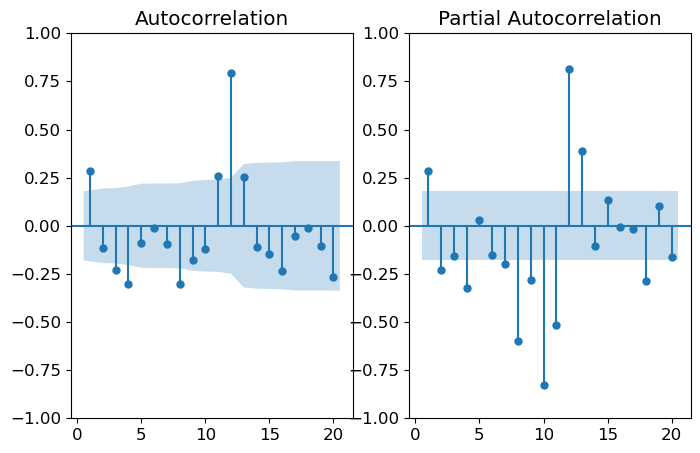

In [36]:
# Primera diferenciación
plot_acf_pacf(diff1_values, {'lags':20})

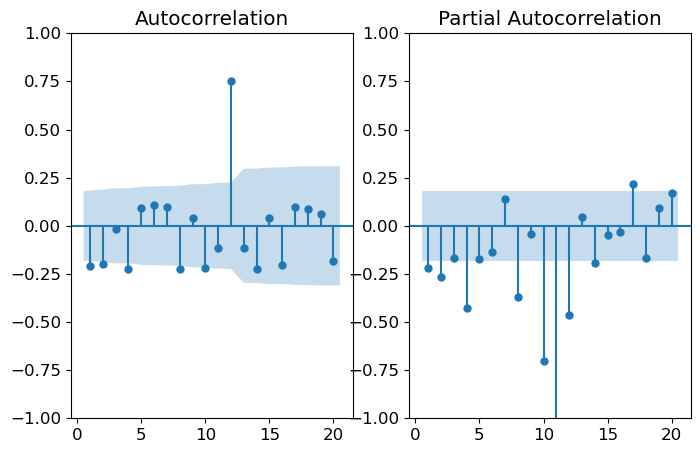

In [37]:
# Autocorrelación primera diferenciación
plot_acf_pacf(diff2_values, {'lags':20})

In [38]:
model_sarimax = sm.tsa.statespace.SARIMAX(train['air'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results = model_sarimax.fit()

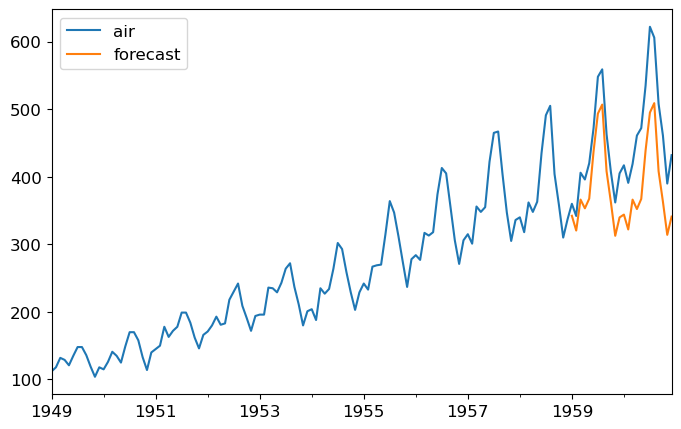

In [39]:
data2['forecast'] = results.predict(start=120,end=144,dynamic=True)
data2[['air','forecast']].plot(figsize=(8,5))
plt.show()

Código de solución estudiante 2

In [ ]:
# Código de solución estudiante 2
.
.
.
.

### Respuesta planteada en el ejercicio
 La respuesta es .........

### Ejercicio 4: Realizar una predicción de 20 unidades de tiempo en el futuro, tanto para el modelo ARIMA como SARIMA y reportar los resulados en una gráfica donde se puedan observar los datos reales y los datos predichos.

Código de solución estudiante 1

<AxesSubplot:>

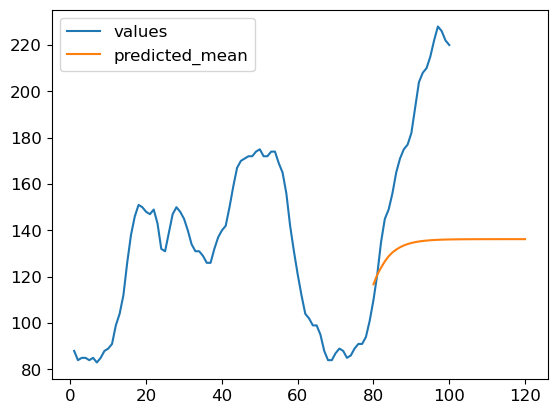

In [40]:
# Cómo realizar predicciones con el modelo ajustado
y_h = model_1.predict(start=80, end=120, dynamic=False).to_frame()
ax = data.plot()
y_h.plot(ax=ax)

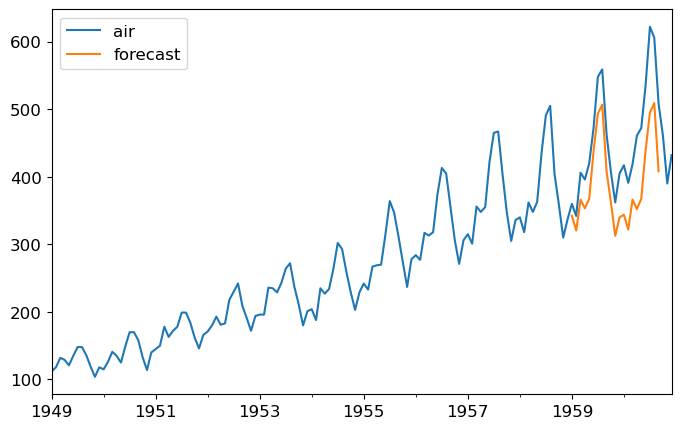

In [41]:
data2['forecast'] = results.predict(start=120,end=140,dynamic=True)
data2[['air','forecast']].plot(figsize=(8,5))
plt.show()

Código de solución estudiante 2

In [ ]:
# Código de solución estudiante 2
.
.
.
.